# About
#### In this notebook, I will analyze the sentiment of users based on their tweets. 
#### I use Sentiment140 dataset. Preprocessing contains removing all hashtags and mentions in tweets. I also remove all tweets containing links inside. Also, some routine preprocessing, such as removing numbers and punctuation marks, has been done.
#### Models I used :


*  One direction LSTM
*  Bidirectional LSTM
*  Pyramid LSTM
*  BERT model in TensorFlow

#### I did tokenizing of words and made embedding layer of the networks by myself, except for the Bert network part that I obtained the TensorFlow document rule. https://www.tensorflow.org/text/tutorials/fine_tune_bert

#### I saved and uploaded the trained models and their history on the [ repository](https://github.com/Omid-SH/Sentiment_Analysis).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [1]:
import pandas as pd
import numpy as np
import re
import time
import pickle
import matplotlib.pylab as plt
import seaborn as sn

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard
from tensorflow.keras.layers import Dense, Input, Flatten, GaussianNoise, GaussianDropout, Dropout, BatchNormalization, Embedding, LSTM, Bidirectional


# Imports we need for bert part

import os

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

!pip install -q -U tensorflow-text
!pip install -q tf-models-official==2.4.0

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks
from official.nlp import optimization

# Prepare dataset

In [ ]:
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

--2022-01-14 08:51:15--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2022-01-14 08:51:15--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  40.4MB/s    in 1.9s    

2022-01-14 08:51:17 (40.4 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]



In [ ]:
!unzip -q trainingandtestdata.zip

In [ ]:
cols = ['sentiment','id','date','query_string','user','text'] #Defining the columns
df = pd.read_csv('./training.1600000.processed.noemoticon.csv', header = None, encoding = 'latin-1', names = cols)
df.head(100)

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
95,0,1467836448,Mon Apr 06 22:26:27 PDT 2009,NO_QUERY,Dogbook,Strider is a sick little puppy http://apps.fa...
96,0,1467836500,Mon Apr 06 22:26:28 PDT 2009,NO_QUERY,natalieantipas,"so rylee,grace...wana go steve's party or not?..."
97,0,1467836576,Mon Apr 06 22:26:29 PDT 2009,NO_QUERY,timdonnelly,"hey, I actually won one of my bracket pools! T..."
98,0,1467836583,Mon Apr 06 22:26:29 PDT 2009,NO_QUERY,homeworld,"@stark YOU don't follow me, either and i work..."


In [ ]:
df['sentiment'].unique()

array([0, 4])

In [ ]:
# We just need sentiment and text of each tweet
df.drop(columns = ['id','date','query_string','user'], axis=1, inplace=True)

In [9]:
# data structure of our data
# we will add other fileds for each data during the code
class sentiment_data():
  def __init__(self, label, text):
    self.label = label
    self.text = text

In [ ]:
# generate negative and positive texts and labels list
train_data = []

for index, row in df.iterrows():
  label = 0
  if row['sentiment'] == 4:
    label = 1
  train_data.append(sentiment_data(label, row['text']))

In [ ]:
len(train_data)

1600000

In [ ]:
max_l = 40 # I have run the code one time and found the max length of text after preprocessing
# # finding maximum tweet text
# max_l = 0
# for item in pr_train_dataset:
#   max_l = max(max_l, len(item.prt))
# print(max_l)

In [ ]:
# prprocess texts
print('prprocessing texts ... ')

word2indx = {}
word2indx['<PAD>'] = 0
word_index = 1

i_select = []
for index, item in enumerate(train_data):
    temp = item.text
    temp = temp.lower()

    # search for site links
    if(not bool(re.search('http:\/\/[^ ]*|https:\/\/[^ ]*|www\.[^ ]*', temp))):

      # remove captions and mentions
      temp = re.sub(r'@[^\s]+', '', temp) 
      temp = re.sub(r'#[^\s]+', '', temp) 

      # remove one digit characters (also removes pounctuations in our dataset texts)
      temp = re.sub(r'(^| ).($| )', ' ', temp)
      # remove digites more than one 
      temp = re.sub(r'(^| )\d+($| )', ' ', temp)
      # remove 's
      temp = re.sub(r'\'s($| )', '', temp) 
      # remove the an
      temp = re.sub(r'(^| )(the|an)($| )', ' ', temp) 

      # remove all other nonimportand items in train_data
      temp = re.sub('[^\w\s]', '', temp)

      # remove all extra spaces in begginig or end of the text line
      temp = re.sub(r'^\s+|\s+$', '', temp)

      temp_out = np.zeros(max_l)
      shift_temp = max_l - len(temp.split())

      # add padding at the end of each sentence and bulding out tokenizer
      for w_index, word in enumerate(temp.split()):
        if word in word2indx.keys():
            temp_out[shift_temp + w_index] = word2indx[word]
        else:
            word2indx[word] = word_index
            temp_out[shift_temp + w_index] = word_index
            word_index += 1

      item.feature_vector = temp_out
      i_select.append(index)

    if(index%100000 == 0):
      print(index)

pr_train_dataset = []

for i in i_select:
  pr_train_dataset.append(train_data[i])

print('Prprocessing texts ... Done.')

prprocessing texts ... 
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
Prprocessing texts ... Done.


In [ ]:
word_index

462953

In [ ]:
len(pr_train_dataset)

1523416

In [ ]:
pr_train_dataset[3721].feature_vector

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,  606.,   49.,
        285.,  793.,    9., 1957.,  124.,  247.,  852., 4390.,  536.,
         49.,  241.,   57., 5899.])

In [ ]:
with open('./drive/MyDrive/data/sentiment140/train_dataset.pkl', 'wb') as f:
    pickle.dump(pr_train_dataset, f)

In [ ]:
with open('./drive/MyDrive/data/sentiment140/word2indx.pkl', 'wb') as f:
    pickle.dump(word2indx, f)

In [10]:
with open('./drive/MyDrive/data/sentiment140/train_dataset.pkl', 'rb') as f:
    train_dataset = pickle.load(f)

In [ ]:
with open('./drive/MyDrive/data/sentiment140/word2indx.pkl', 'rb') as f:
    word2indx = pickle.load(f)

## Glove

In [ ]:
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip

--2022-01-14 10:53:01--  http://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.42B.300d.zip [following]
--2022-01-14 10:53:01--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2022-01-14 10:53:01--  http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]
Sav

In [ ]:
!unzip -q glove.42B.300d.zip

In [ ]:
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

In [ ]:
glove_model = load_glove_model('./glove.42B.300d.txt')
# glove_model = load_glove_model('./drive/MyDrive/data/flick8k/glove/glove.6B.300d.txt')

Loading Glove Model
1917494 words loaded!


In [ ]:
embedding_dim = len(glove_model['apple'])
embedding_dim

300

In [ ]:
vocab_size = len(word2indx)
vocab_size

462953

In [ ]:
def get_weight_matrix(embedding, word2indx):
    mean = np.mean(np.array(list(embedding.values())), axis=0)

    weight_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word2indx.items():
        vector = embedding.get(word)
        if vector is not None:
            weight_matrix[i] = vector
        else : 
            weight_matrix[i] = mean
    return weight_matrix

In [ ]:
embedding_matrix = get_weight_matrix(glove_model, word2indx)

In [ ]:
embedding_matrix.shape

(462953, 300)

In [ ]:
import pickle
with open('./drive/MyDrive/data/sentiment140/embedding_matrix.pkl', 'wb') as f:
    pickle.dump(embedding_matrix, f)

In [8]:
import pickle
with open('./drive/MyDrive/data/sentiment140/embedding_matrix.pkl', 'rb') as f:
    embedding_matrix = pickle.load(f)

# Divide data into Test, Train, and Validation

In [11]:
# find number of positive and negetive tweets
pos_count = 0
neg_count = 0
for item in train_dataset:
  if item.label == 0:
    pos_count += 1
  else:
    neg_count += 1

print('Posetive tweets :', pos_count)
print('Negetive tweets :', neg_count)

Posetive tweets : 774507
Negetive tweets : 748909


In [12]:
max_l = 40
X = np.zeros((pos_count+neg_count, max_l))
Y = np.zeros((pos_count+neg_count, 2))

for index, item in enumerate(train_dataset):
  X[index, :] = item.feature_vector
  if item.label == 0:
    Y[index, :] = [1, 0]
  else:
    Y[index, :] = [0, 1]

In [ ]:
X[10, :]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 87., 88., 35.,
       89.])

In [13]:
# divide dataset

# shaffle learning 
np.random.seed(1234321)
permutation = np.random.choice(range(X.shape[0]), X.shape[0], False)
X = X[permutation]
Y = Y[permutation]

# select train, test, and validation (70% 15% 15%)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

X_train = X[0:int(train_ratio*X.shape[0])]
Y_train = Y[0:int(train_ratio*X.shape[0])]

X_val = X[int(train_ratio*X.shape[0]):int((train_ratio + val_ratio)*X.shape[0])]
Y_val = Y[int(train_ratio*X.shape[0]):int((train_ratio + val_ratio)*X.shape[0])]

X_test = X[int((train_ratio + val_ratio)*X.shape[0]):]
Y_test = Y[int((train_ratio + val_ratio)*X.shape[0]):]

# Make LSTM Models

In [ ]:
embedding_matrix.shape

(462953, 300)

In [ ]:
# create the embedding layer
embedding_layer = Embedding(embedding_matrix.shape[0], 
                            embedding_matrix.shape[1], 
                            weights = [embedding_matrix], 
                            input_length = max_l, 
                            trainable = False)

## One direction LSTM

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(150))
model.add(Dense(2, activation = "sigmoid"))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer= optimizer,loss='binary_crossentropy', metrics='accuracy')

#Call backs
def scheduler(epoch, lr):
  return lr/1.07

lr_cb = LearningRateScheduler(scheduler)

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 40, 300)           138885900 
                                                                 
 lstm_11 (LSTM)              (None, 150)               270600    
                                                                 
 dense_10 (Dense)            (None, 2)                 302       
                                                                 
Total params: 139,156,802
Trainable params: 270,902
Non-trainable params: 138,885,900
_________________________________________________________________


In [ ]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=1024, validation_data=(X_val, Y_val), callbacks=[lr_cb])

Epoch 1/20
1042/1042 [==============================] - 70s 65ms/step - loss: 0.4230 - accuracy: 0.8033 - val_loss: 0.3966 - val_accuracy: 0.8179 - lr: 0.0093
Epoch 2/20
1042/1042 [==============================] - 68s 65ms/step - loss: 0.3844 - accuracy: 0.8254 - val_loss: 0.3904 - val_accuracy: 0.8210 - lr: 0.0087
Epoch 3/20
1042/1042 [==============================] - 68s 65ms/step - loss: 0.3675 - accuracy: 0.8347 - val_loss: 0.3897 - val_accuracy: 0.8230 - lr: 0.0082
Epoch 4/20
1042/1042 [==============================] - 68s 65ms/step - loss: 0.3542 - accuracy: 0.8417 - val_loss: 0.3914 - val_accuracy: 0.8230 - lr: 0.0076
Epoch 5/20
1042/1042 [==============================] - 68s 65ms/step - loss: 0.3415 - accuracy: 0.8486 - val_loss: 0.3945 - val_accuracy: 0.8227 - lr: 0.0071
Epoch 6/20
1042/1042 [==============================] - 68s 66ms/step - loss: 0.3290 - accuracy: 0.8550 - val_loss: 0.4000 - val_accuracy: 0.8221 - lr: 0.0067
Epoch 7/20
1042/1042 [========================

In [4]:
model.save('./drive/MyDrive/DeepLearning_HW3/Sentiment_Analysis/models/rnn_one')

hist_df = pd.DataFrame(history.history)
with open('./drive/MyDrive/DeepLearning_HW3/Sentiment_Analysis/models/rnn_one/history.csv', mode='w') as f:
    hist_df.to_csv(f)

NameError: ignored

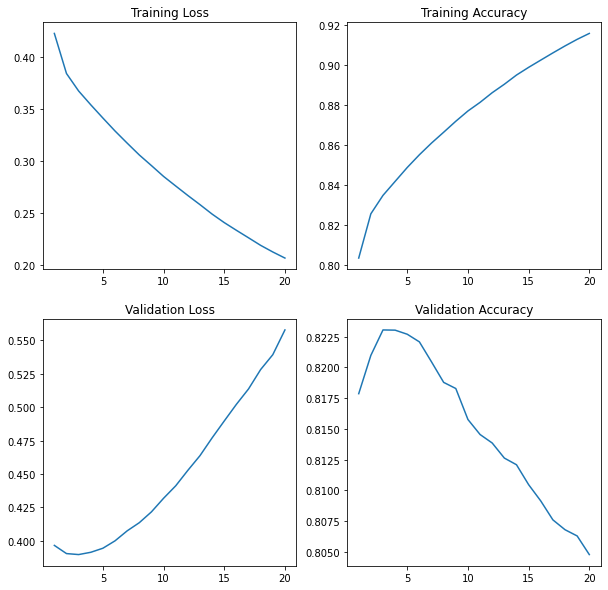

In [5]:
# Draw accuracy and loss 
history = pd.read_csv('./drive/MyDrive/DeepLearning_HW3/Sentiment_Analysis/models/rnn_one/history.csv')
plt.rcParams['figure.figsize'] = [10, 10]
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
ax.set_title('Training Loss')
plt.plot(range(1, len(history['loss']) + 1), history['loss'])
ax = fig.add_subplot(2, 2, 2)
ax.set_title('Training Accuracy')
plt.plot(range(1, len(history['accuracy']) + 1), history['accuracy'])
ax = fig.add_subplot(2, 2, 3)
ax.set_title('Validation Loss')
plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'])
ax = fig.add_subplot(2, 2, 4)
ax.set_title('Validation Accuracy')
plt.plot(range(1, len(history['val_accuracy']) + 1), history['val_accuracy'])

7142/7142 [==============================] - 26s 4ms/step - loss: 0.5622 - accuracy: 0.8038
Test Loss =  0.5621944665908813
Test Accuracy =  0.8037748336791992


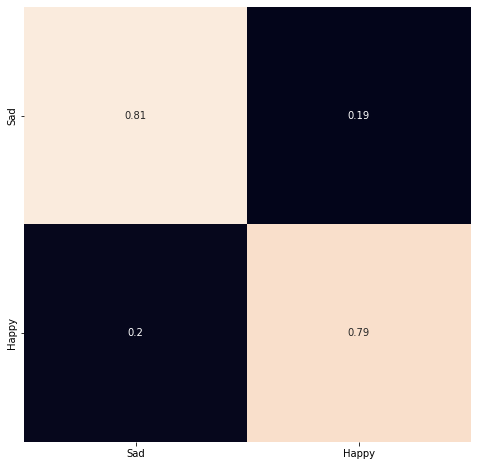

In [15]:
# Confusion matrix
class_names = ['Sad', 'Happy']
num_calsses = 2

model = tf.keras.models.load_model('./drive/MyDrive/DeepLearning_HW3/Sentiment_Analysis/models/rnn_one')
[test_loss, test_accuracy] = model.evaluate(X_test, Y_test)
print('Test Loss = ', test_loss)
print('Test Accuracy = ', test_accuracy)

predicted_Y_test = model.predict(X_test)
confusion_matrix = tf.math.confusion_matrix(np.argmax(Y_test, axis=-1), np.argmax(predicted_Y_test, axis=-1), num_calsses).numpy()
confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=1)
df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
plt.figure(figsize=(8, 8))
sn.heatmap(df, annot=True, cbar=False)

## Two directional LSTM

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(150)))
model.add(Dense(2, activation = "sigmoid"))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer= optimizer,loss='binary_crossentropy', metrics='accuracy')

#Call backs
def scheduler(epoch, lr):
  return lr/1.07

lr_cb = LearningRateScheduler(scheduler)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 300)           138885900 
                                                                 
 bidirectional (Bidirectiona  (None, 300)              541200    
 l)                                                              
                                                                 
 dense (Dense)               (None, 2)                 602       
                                                                 
Total params: 139,427,702
Trainable params: 541,802
Non-trainable params: 138,885,900
_________________________________________________________________


In [ ]:
history = model.fit(X_train, Y_train, epochs=10, batch_size=1024, validation_data=(X_val, Y_val), callbacks=[lr_cb])

Epoch 1/10
1042/1042 [==============================] - 144s 131ms/step - loss: 0.4231 - accuracy: 0.8035 - val_loss: 0.3971 - val_accuracy: 0.8179 - lr: 0.0093
Epoch 2/10
1042/1042 [==============================] - 138s 132ms/step - loss: 0.3833 - accuracy: 0.8261 - val_loss: 0.3886 - val_accuracy: 0.8230 - lr: 0.0087
Epoch 3/10
1042/1042 [==============================] - 138s 132ms/step - loss: 0.3670 - accuracy: 0.8349 - val_loss: 0.3897 - val_accuracy: 0.8235 - lr: 0.0082
Epoch 4/10
1042/1042 [==============================] - 138s 132ms/step - loss: 0.3531 - accuracy: 0.8424 - val_loss: 0.3925 - val_accuracy: 0.8228 - lr: 0.0076
Epoch 5/10
1042/1042 [==============================] - 138s 132ms/step - loss: 0.3407 - accuracy: 0.8492 - val_loss: 0.3935 - val_accuracy: 0.8224 - lr: 0.0071
Epoch 6/10
1042/1042 [==============================] - 137s 132ms/step - loss: 0.3286 - accuracy: 0.8549 - val_loss: 0.4015 - val_accuracy: 0.8219 - lr: 0.0067
Epoch 7/10
1042/1042 [============

In [ ]:
model.save('./drive/MyDrive/DeepLearning_HW3/Sentiment_Analysis/models/rnn_bi')

hist_df = pd.DataFrame(history.history)
with open('./drive/MyDrive/DeepLearning_HW3/Sentiment_Analysis/models/rnn_bi/history.csv', mode='w') as f:
    hist_df.to_csv(f)

INFO:tensorflow:Assets written to: ./drive/MyDrive/DeepLearning_HW3/Sentiment_Analysis/models/rnn_bi/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/DeepLearning_HW3/Sentiment_Analysis/models/rnn_bi/assets


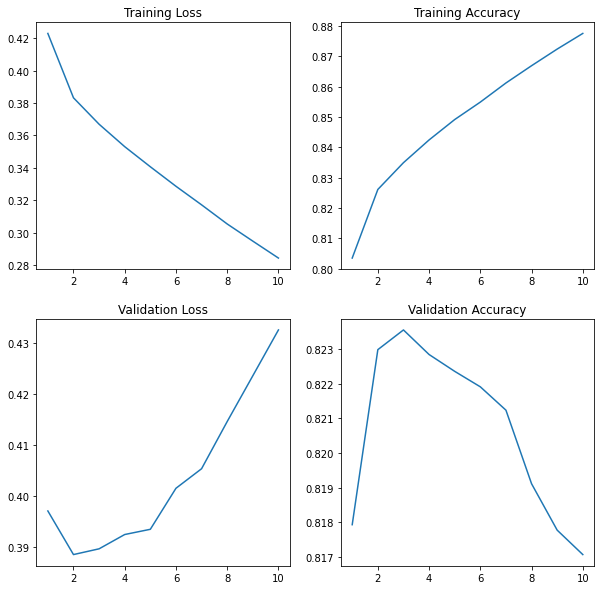

In [ ]:
# Draw accuracy and loss 
history = pd.read_csv('./drive/MyDrive/DeepLearning_HW3/Sentiment_Analysis/models/rnn_bi/history.csv')
plt.rcParams['figure.figsize'] = [10, 10]
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
ax.set_title('Training Loss')
plt.plot(range(1, len(history['loss']) + 1), history['loss'])
ax = fig.add_subplot(2, 2, 2)
ax.set_title('Training Accuracy')
plt.plot(range(1, len(history['accuracy']) + 1), history['accuracy'])
ax = fig.add_subplot(2, 2, 3)
ax.set_title('Validation Loss')
plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'])
ax = fig.add_subplot(2, 2, 4)
ax.set_title('Validation Accuracy')
plt.plot(range(1, len(history['val_accuracy']) + 1), history['val_accuracy'])

7142/7142 [==============================] - 80s 11ms/step - loss: 0.4350 - accuracy: 0.8149
Test Loss =  0.4349540174007416
Test Accuracy =  0.8149164319038391


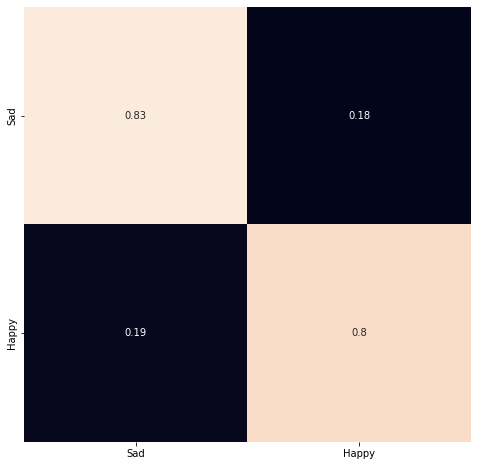

In [ ]:
# Confusion matrix
class_names = ['Sad', 'Happy']
num_calsses = 2

model = tf.keras.models.load_model('./drive/MyDrive/DeepLearning_HW3/Sentiment_Analysis/models/rnn_bi')
[test_loss, test_accuracy] = model.evaluate(X_test, Y_test)
print('Test Loss = ', test_loss)
print('Test Accuracy = ', test_accuracy)

predicted_Y_test = model.predict(X_test)
confusion_matrix = tf.math.confusion_matrix(np.argmax(Y_test, axis=-1), np.argmax(predicted_Y_test, axis=-1), num_calsses).numpy()
confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=1)
df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
plt.figure(figsize=(8, 8))
sn.heatmap(df, annot=True, cbar=False)

## Pyramid model

In [ ]:
input = Input(shape=max_l, name='Input')

# Pyramid Layer 1
input_1 = embedding_layer(input)
lstm_1 = LSTM(64, return_sequences=True)(input_1)

# Pyramid Layer 2
input_2 = tf.concat([tf.gather(lstm_1, range(0, max_l, 2), axis=1), tf.gather(lstm_1, range(1, max_l+1, 2), axis=1)], axis=2)
lstm_2 = LSTM(128, return_sequences=True)(input_2)

# Pyramid Layer 3
input_3 = tf.concat([tf.gather(lstm_2, range(0, int(max_l/2), 2), axis=1), tf.gather(lstm_2, range(1, int(max_l/2)+1, 2), axis=1)], axis=2)
lstm_3 = LSTM(256, return_sequences=True)(input_3)

# Pyramid Layer 4
input_4 = tf.concat([tf.gather(lstm_3, range(0, int(max_l/4), 2), axis=1), tf.gather(lstm_3, range(1, int(max_l/4)+1, 2), axis=1)], axis=2)
lstm_4 = LSTM(512)(input_4)

fc = Dense(100, activation='ReLU', name='FC')(lstm_4)
output = Dense(2, activation='sigmoid', name='Output')(fc)

model = tf.keras.Model(inputs=input, outputs=output)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

model.compile(optimizer= optimizer,loss='binary_crossentropy', metrics='accuracy')

#Call backs
def scheduler(epoch, lr):
  return lr/1.07

lr_cb = LearningRateScheduler(scheduler)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 300)      138885900   ['Input[0][0]']                  
                                                                                                  
 lstm_1 (LSTM)                  (None, 40, 64)       93440       ['embedding[1][0]']              
                                                                                                  
 tf.compat.v1.gather (TFOpLambd  (None, 20, 64)      0           ['lstm_1[0][0]']                 
 a)                                                                                           

In [ ]:
history = model.fit(X_train, Y_train, epochs=10, batch_size=1024, validation_data=(X_val, Y_val), callbacks=[lr_cb])

Epoch 1/10
1042/1042 [==============================] - 135s 120ms/step - loss: 0.4309 - accuracy: 0.7971 - val_loss: 0.3971 - val_accuracy: 0.8193 - lr: 0.0047
Epoch 2/10
1042/1042 [==============================] - 123s 118ms/step - loss: 0.3860 - accuracy: 0.8251 - val_loss: 0.3867 - val_accuracy: 0.8247 - lr: 0.0044
Epoch 3/10
1042/1042 [==============================] - 123s 119ms/step - loss: 0.3697 - accuracy: 0.8337 - val_loss: 0.3829 - val_accuracy: 0.8263 - lr: 0.0041
Epoch 4/10
1042/1042 [==============================] - 123s 118ms/step - loss: 0.3569 - accuracy: 0.8404 - val_loss: 0.3855 - val_accuracy: 0.8278 - lr: 0.0038
Epoch 5/10
1042/1042 [==============================] - 123s 118ms/step - loss: 0.3448 - accuracy: 0.8465 - val_loss: 0.3869 - val_accuracy: 0.8249 - lr: 0.0036
Epoch 6/10
1042/1042 [==============================] - 123s 118ms/step - loss: 0.3322 - accuracy: 0.8530 - val_loss: 0.3938 - val_accuracy: 0.8254 - lr: 0.0033
Epoch 7/10
1042/1042 [============

In [ ]:
model.save('./drive/MyDrive/DeepLearning_HW3/Sentiment_Analysis/models/pyramidal_lstm')

hist_df = pd.DataFrame(history.history)
with open('./drive/MyDrive/DeepLearning_HW3/Sentiment_Analysis/models/pyramidal_lstm/history.csv', mode='w') as f:
    hist_df.to_csv(f)

INFO:tensorflow:Assets written to: ./drive/MyDrive/DeepLearning_HW3/Sentiment_Analysis/models/pyramidal_lstm/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/DeepLearning_HW3/Sentiment_Analysis/models/pyramidal_lstm/assets


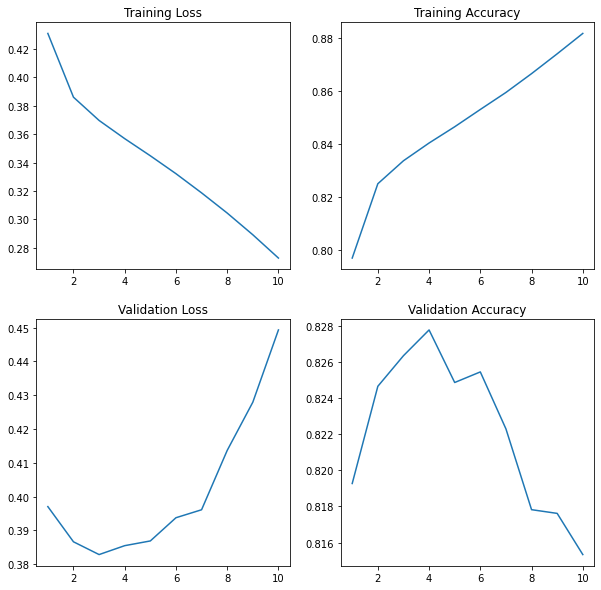

In [ ]:
# Draw accuracy and loss 
history = pd.read_csv('./drive/MyDrive/DeepLearning_HW3/Sentiment_Analysis/models/pyramidal_lstm/history.csv')
plt.rcParams['figure.figsize'] = [10, 10]
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
ax.set_title('Training Loss')
plt.plot(range(1, len(history['loss']) + 1), history['loss'])
ax = fig.add_subplot(2, 2, 2)
ax.set_title('Training Accuracy')
plt.plot(range(1, len(history['accuracy']) + 1), history['accuracy'])
ax = fig.add_subplot(2, 2, 3)
ax.set_title('Validation Loss')
plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'])
ax = fig.add_subplot(2, 2, 4)
ax.set_title('Validation Accuracy')
plt.plot(range(1, len(history['val_accuracy']) + 1), history['val_accuracy'])

7142/7142 [==============================] - 44s 6ms/step - loss: 0.4515 - accuracy: 0.8146
Test Loss =  0.4514535963535309
Test Accuracy =  0.8146363496780396


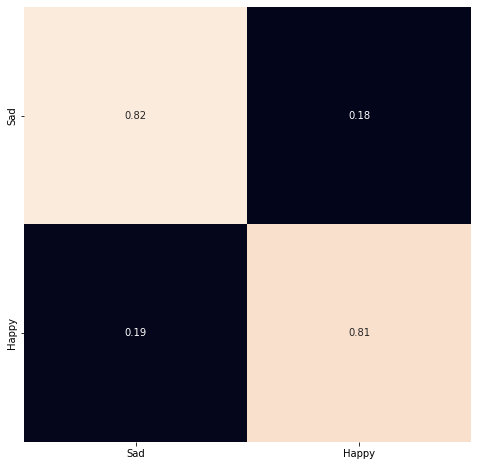

In [16]:
# Confusion matrix
class_names = ['Sad', 'Happy']
num_calsses = 2

model = tf.keras.models.load_model('./drive/MyDrive/DeepLearning_HW3/Sentiment_Analysis/models/pyramidal_lstm')
[test_loss, test_accuracy] = model.evaluate(X_test, Y_test)
print('Test Loss = ', test_loss)
print('Test Accuracy = ', test_accuracy)

predicted_Y_test = model.predict(X_test)
confusion_matrix = tf.math.confusion_matrix(np.argmax(Y_test, axis=-1), np.argmax(predicted_Y_test, axis=-1), num_calsses).numpy()
confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=1)
df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
plt.figure(figsize=(8, 8))
sn.heatmap(df, annot=True, cbar=False)

# BERT (+)

## Prepare data

In [ ]:
# prprocess texts
print('prprocessing texts for bert ... ')

for index, item in enumerate(train_dataset):
    temp = item.text
    temp = temp.lower()

    # remove captions and mentions
    temp = re.sub(r'@[^\s]+', '', temp) 
    temp = re.sub(r'#[^\s]+', '', temp) 

    # remove one digit characters (also removes pounctuations in our dataset texts)
    temp = re.sub(r'(^| ).($| )', ' ', temp)
    # remove digites more than one 
    temp = re.sub(r'(^| )\d+($| )', ' ', temp)
    # remove 's
    temp = re.sub(r'\'s($| )', '', temp) 
    # remove the an
    temp = re.sub(r'(^| )(the|an)($| )', ' ', temp) 

    # remove all other nonimportand items in train_data
    temp = re.sub('[^\w\s]', '', temp)

    # remove all extra spaces in begginig or end of the text line
    temp = re.sub(r'^\s+|\s+$', '', temp)

    item.bert_text = temp

    if(index%100000 == 0):
      print(index)

print('Prprocessing texts for bert ... Done.')

prprocessing texts for bert ... 
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
Prprocessing texts for bert ... Done.


In [4]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/2"
bert_layer = hub.KerasLayer(hub_url_bert,
                            trainable=True)

In [5]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [3]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
max_l = 40
X = []
Y = np.zeros((len(train_dataset), 2))

for index, item in enumerate(train_dataset):
  X.append(item.bert_text)
  if item.label == 0:
    Y[index, :] = [1, 0]
  else:
    Y[index, :] = [0, 1]

In [ ]:
with open('./drive/MyDrive/data/sentiment140/X_bert.pkl', 'wb') as f:
  pickle.dump(X, f)
with open('./drive/MyDrive/data/sentiment140/Y_bert.pkl', 'wb') as f:
  pickle.dump(Y, f)

In [2]:
with open('./drive/MyDrive/data/sentiment140/X_bert.pkl', 'rb') as f:
  X = pickle.load(f)
with open('./drive/MyDrive/data/sentiment140/Y_bert.pkl', 'rb') as f:
  Y = pickle.load(f)

In [6]:
# divide dataset

# shaffle learning 
np.random.seed(1234321)
permutation = np.random.choice(range(Y.shape[0]), Y.shape[0], False)
X = [X[i] for i in permutation]
Y = Y[permutation]

# select train, test, and validation (70% 15% 15%)
train_ratio = 0.5
val_ratio = 0.1
test_ratio = 0.1

X_train = bert_encode(X[0:int(train_ratio*Y.shape[0])],tokenizer, 40)
Y_train = Y[0:int(train_ratio*Y.shape[0])]

X_val = bert_encode(X[int(train_ratio*Y.shape[0]):int((train_ratio + val_ratio)*Y.shape[0])], tokenizer, 40)
Y_val = Y[int(train_ratio*Y.shape[0]):int((train_ratio + val_ratio)*Y.shape[0])]

X_test = bert_encode(X[int((train_ratio + val_ratio)*Y.shape[0]):int((train_ratio + val_ratio + test_ratio)*Y.shape[0])], tokenizer, 40)
Y_test = Y[int((train_ratio + val_ratio)*Y.shape[0]):int((train_ratio + val_ratio + test_ratio)*Y.shape[0])]

In [7]:
X_train['input_word_ids'].shape

TensorShape([761708, 40])

In [8]:
num_class = 2
max_seq_length = 40 

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.3)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 40)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 40)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        108310273   ['input_word_ids[0][0]',         
                                 (None, 40, 768)]                 'input_mask[0][0]',         

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer= optimizer,loss='categorical_crossentropy', metrics='accuracy')

In [12]:
history = model.fit(X_train, Y_train, epochs=1, batch_size=200, validation_data=(X_val, Y_val))

3809/3809 [==============================] - 6172s 2s/step - loss: 0.3877 - accuracy: 0.8260 - val_loss: 0.3628 - val_accuracy: 0.8374


In [13]:
model.save('./drive/MyDrive/DeepLearning_HW3/Sentiment_Analysis/models/bert')

hist_df = pd.DataFrame(history.history)
with open('./drive/MyDrive/DeepLearning_HW3/Sentiment_Analysis/models/bert/history.csv', mode='w') as f:
    hist_df.to_csv(f)

INFO:tensorflow:Assets written to: ./drive/MyDrive/DeepLearning_HW3/Sentiment_Analysis/models/bert/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/DeepLearning_HW3/Sentiment_Analysis/models/bert/assets


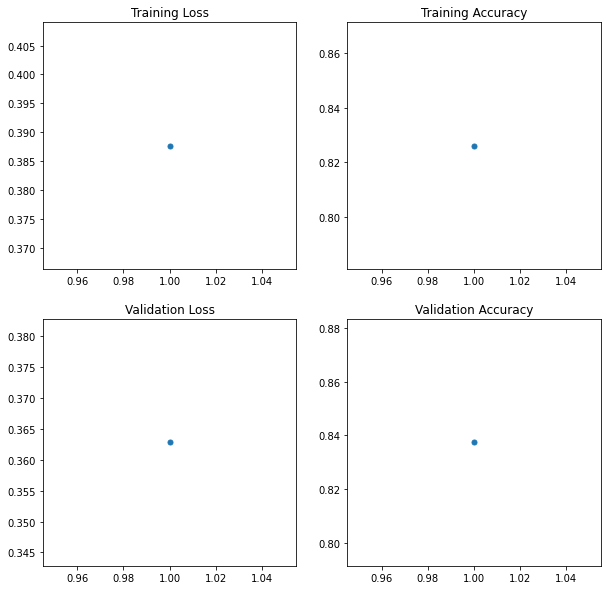

In [22]:
# Draw accuracy and loss 
history = pd.read_csv('./drive/MyDrive/DeepLearning_HW3/Sentiment_Analysis/models/bert/history.csv')
plt.rcParams['figure.figsize'] = [10, 10]
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
ax.set_title('Training Loss')
plt.plot(range(1, len(history['loss']) + 1), history['loss'], marker = '.', markersize=10)
ax = fig.add_subplot(2, 2, 2)
ax.set_title('Training Accuracy')
plt.plot(range(1, len(history['accuracy']) + 1), history['accuracy'], marker = '.', markersize=10)
ax = fig.add_subplot(2, 2, 3)
ax.set_title('Validation Loss')
plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'], marker = '.', markersize=10)
ax = fig.add_subplot(2, 2, 4)
ax.set_title('Validation Accuracy')
plt.plot(range(1, len(history['val_accuracy']) + 1), history['val_accuracy'], marker = '.', markersize=10)

4761/4761 [==============================] - 421s 88ms/step - loss: 0.3621 - accuracy: 0.8383
Test Loss =  0.3621320426464081
Test Accuracy =  0.8383177518844604


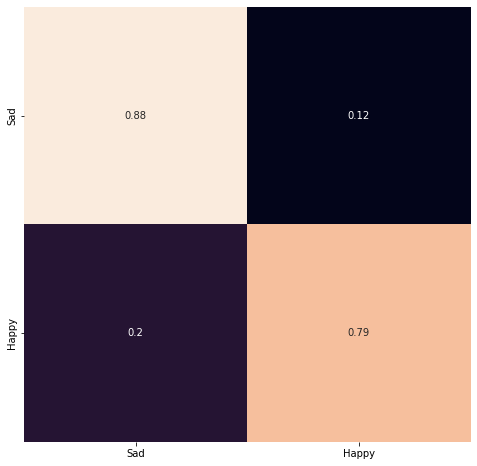

In [15]:
# Confusion matrix
class_names = ['Sad', 'Happy']
num_calsses = 2

model = tf.keras.models.load_model('./drive/MyDrive/DeepLearning_HW3/Sentiment_Analysis/models/bert')
[test_loss, test_accuracy] = model.evaluate(X_test, Y_test)
print('Test Loss = ', test_loss)
print('Test Accuracy = ', test_accuracy)

predicted_Y_test = model.predict(X_test)
confusion_matrix = tf.math.confusion_matrix(np.argmax(Y_test, axis=-1), np.argmax(predicted_Y_test, axis=-1), num_calsses).numpy()
confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=1)
df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
plt.figure(figsize=(8, 8))
sn.heatmap(df, annot=True, cbar=False)

# Comparing the results and networks

As you can see from the above results, all four networks' results on training, validation, and test data are ok and similar to each other. For my case, first, the pyramidal model accuracy, then the bi-directional LSTM accuracy, and finally, the 1-directional LSTM accuracy increases faster.
For the Bert model, based on our computational limitation on the google colab, we could just run the model for one epoch that took about 1 hour. But the model accuracy is as good as (or even better than) other models.

One important thing for both 1-directional LSTM and bi-directional LSTM is that the training accuracy increases during the epochs and becomes something around 96%. It shows us that we can improve their accuracy on validation and test data by using dropout and adding one FC layer.

Comparing the models' parameters, 1-direction LSTM contains about 300,000 trainable parameters, half of the bi-directional model.
The pyramidal LSTM model contains about 3M parameters, and Bert has 108M!
This difference of orders of the model's parameters can be seen in the time consumed by each network for learning the problem.

All other results, confusion matrixes, accuracy, and model histories are available inside the notebook and the [ repository](https://github.com/Omid-SH/Sentiment_Analysis).